In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import datetime

In [3]:
#load data
df = pd.read_csv('pd_collisions_datasd.csv')

print(df.shape)
print(df.head())
print(df.isna().sum())

(65084, 16)
  report_id            date_time  police_beat  address_no_primary  \
0    192016  2015-03-19 12:00:00          622                5200   
1    190012  2015-03-24 03:05:00          626                1000   
2    191866  2015-03-27 23:56:00          613                2800   
3    185207  2015-07-06 11:45:00          813                2800   
4   1608987  2015-08-22 13:45:00          999                   0   

  address_pd_primary address_road_primary address_sfx_primary  \
0                             LINDA VISTA                ROAD   
1                  W           WASHINGTON              STREET   
2                                  WORDEN              STREET   
3                                EL CAJON           BOULEVARD   
4                           DE ANZA POINT                       

  address_pd_intersecting address_name_intersecting address_sfx_intersecting  \
0                                                                              
1                     

In [4]:
# fixing datetime
df['date_time'] = pd.to_datetime(df['date_time'])

df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month
df['is_weekend'] = df['day_of_week'].apply(lambda x: x >= 5)
df['rush_hour'] = df['hour'].apply(lambda x: 7 <= x <= 9 or 16 <= x <= 18)

# 5. Target Engineering (severity)
df['severity'] = df['injured'] + 3 * df['killed']
df['severity_label'] = pd.cut(df['severity'], bins=[-1, 0, 2, 100], labels=['none', 'injury', 'fatal'])

In [5]:
# selecting features
features = ['hour', 'day_of_week', 'month', 'is_weekend', 'rush_hour', 
            'police_beat', 'violation_type', 'hit_run_lvl']
target = 'severity_label'

df_model = df[features + [target]].dropna()

In [6]:
# encode categorical features
cat_cols = ['police_beat', 'violation_type', 'hit_run_lvl']
for col in cat_cols:
    df_model[col] = LabelEncoder().fit_transform(df_model[col].astype(str))

df_model['is_weekend'] = df_model['is_weekend'].astype(int)
df_model['rush_hour'] = df_model['rush_hour'].astype(int)

In [7]:
# train/test split
X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
#model training
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

       fatal       0.00      0.00      0.00        41
      injury       0.30      0.13      0.18       814
        none       0.87      0.96      0.91      5235

    accuracy                           0.84      6090
   macro avg       0.39      0.36      0.36      6090
weighted avg       0.79      0.84      0.81      6090



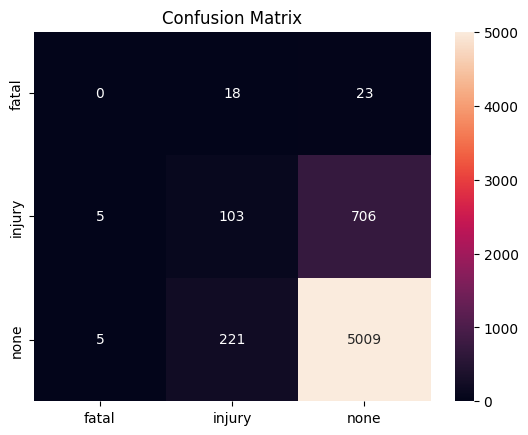

In [9]:
# eval
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title("Confusion Matrix")
plt.show()

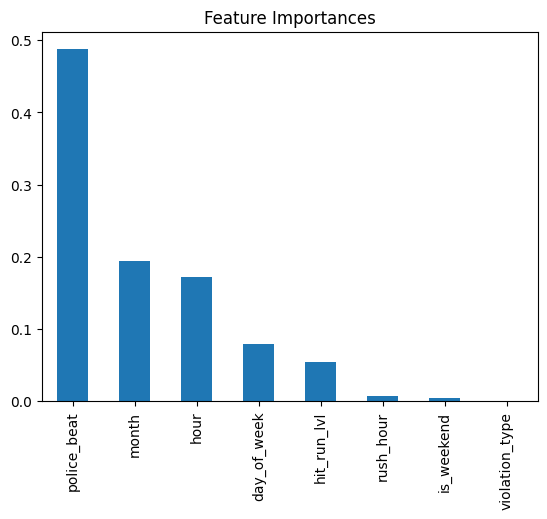

In [10]:
# feature importance 
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.show()

In [16]:
# Model is bad so lets try training it better using resampling
from sklearn.utils import resample

# separate classes
df_none = df_model[df_model[target] == 'none']
df_injury = df_model[df_model[target] == 'injury']
df_fatal = df_model[df_model[target] == 'fatal']

# unpsample minority classes
df_injury_upsampled = resample(df_injury, 
                               replace=True, 
                               n_samples=len(df_none), 
                               random_state=42)

df_fatal_upsampled = resample(df_fatal,
                              replace=True,
                              n_samples=len(df_none),
                              random_state=42)

# combine
df_balanced = pd.concat([df_none, df_injury_upsampled, df_fatal_upsampled])

# shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42)

# split again
X = df_balanced[features]
y = df_balanced[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [17]:
#model training 2
rf_1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_1.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

       fatal       1.00      1.00      1.00      5234
      injury       0.89      0.99      0.94      5235
        none       0.99      0.87      0.93      5235

    accuracy                           0.95     15704
   macro avg       0.96      0.95      0.95     15704
weighted avg       0.96      0.95      0.95     15704



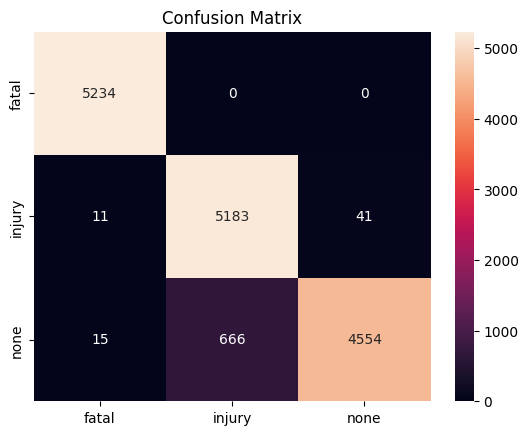

In [18]:
# eval 2
y_pred = rf_1.predict(X_test)
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=rf_1.classes_, yticklabels=rf_1.classes_)
plt.title("Confusion Matrix")
plt.show()

In [19]:
#Testing on the orginal unbalanced test set
y_pred_orig = rf.predict(X_test)
print(classification_report(y_test, y_pred_orig))

              precision    recall  f1-score   support

       fatal       1.00      0.73      0.84      5234
      injury       0.87      0.71      0.78      5235
        none       0.68      0.99      0.81      5235

    accuracy                           0.81     15704
   macro avg       0.85      0.81      0.81     15704
weighted avg       0.85      0.81      0.81     15704



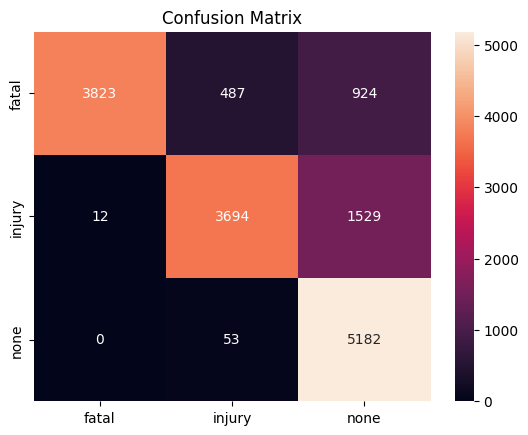

In [20]:
sns.heatmap(confusion_matrix(y_test, y_pred_orig), annot=True, fmt='d', xticklabels=rf_1.classes_, yticklabels=rf_1.classes_)
plt.title("Confusion Matrix")
plt.show()